<a href="https://colab.research.google.com/github/Bossism/DailyStudy/blob/master/Seq2Seq_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip3 install tensorflow_addons

     |████████████████████████████████| 686kB 2.8MB/s 


In [14]:
!touch ./visual/tmp/attention_align.pkl

touch: cannot touch './visual/tmp/attention_align.pkl': No such file or directory


In [15]:
!ls

__pycache__  sample_data  utils.py  visual


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from matplotlib.pyplot import cm
import os
import utils

def seq2seq_attention():
    with open("./visual/tmp/attention_align.pkl", "rb") as f:
        data = pickle.load(f)
    i2v, x, y, align = data["i2v"], data["x"], data["y"], data["align"]
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        x_vocab = [i2v[j] for j in np.ravel(x[i])]
        y_vocab = [i2v[j] for j in y[i, 1:]]
        plt.imshow(align[i], cmap="YlGn", vmin=0., vmax=1.)
        plt.yticks([j for j in range(len(y_vocab))], y_vocab)
        plt.xticks([j for j in range(len(x_vocab))], x_vocab)
        if i == 0 or i == 3:
            plt.ylabel("Output")
        if i >= 3:
            plt.xlabel("Input")
    plt.tight_layout()
    plt.savefig("./visual/results/seq2seq_attention.png", format="png", dpi=200)
    plt.show()

Chinese time order: yy/mm/dd  ['31-04-26', '04-07-18', '33-06-06'] 
English time order: dd/M/yyyy  ['26/Apr/2031', '18/Jul/2004', '06/Jun/2033']
vocabularies:  {'8', 'Apr', 'Feb', 'Jun', '3', '<GO>', '-', '4', '<EOS>', 'Aug', '1', '<PAD>', 'May', '5', 'Jan', '2', '9', '0', 'Nov', 'Sep', '/', 'Oct', 'Mar', 'Jul', 'Dec', '6', '7'}
x index sample: 
31-04-26
[6 4 1 3 7 1 5 9] 
y index sample: 
<GO>26/Apr/2031<EOS>
[14  5  9  2 15  2  5  3  6  4 13]
t:  0 | loss: 3.30062 | input:  89-05-25 | target:  25/May/1989 | inference:  99999999999
t:  70 | loss: 0.17514 | input:  03-09-13 | target:  13/Sep/2003 | inference:  13/Feb/2003<EOS>
t:  140 | loss: 0.00085 | input:  92-06-01 | target:  01/Jun/1992 | inference:  01/Jun/1992<EOS>
t:  210 | loss: 0.00031 | input:  23-01-28 | target:  28/Jan/2023 | inference:  28/Jan/2023<EOS>
t:  280 | loss: 0.00022 | input:  25-08-01 | target:  01/Aug/2025 | inference:  01/Aug/2025<EOS>
t:  350 | loss: 0.00015 | input:  75-04-21 | target:  21/Apr/1975 | infere

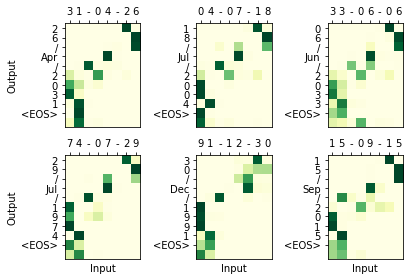

In [24]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import utils    # this refers to utils.py in my [repo](https://github.com/MorvanZhou/NLP-Tutorials/)
import tensorflow_addons as tfa
import pickle


class Seq2Seq(keras.Model):
    def __init__(self, enc_v_dim, dec_v_dim, emb_dim, units, attention_layer_size, max_pred_len, start_token, end_token):
        super().__init__()
        self.units = units

        # encoder
        self.enc_embeddings = keras.layers.Embedding(
            input_dim=enc_v_dim, output_dim=emb_dim,    # [enc_n_vocab, emb_dim]
            embeddings_initializer=tf.initializers.RandomNormal(0., 0.1),
        )
        self.encoder = keras.layers.LSTM(units=units, return_sequences=True, return_state=True)

        # decoder
        self.attention = tfa.seq2seq.LuongAttention(units, memory=None, memory_sequence_length=None)
        self.decoder_cell = tfa.seq2seq.AttentionWrapper(
            cell=keras.layers.LSTMCell(units=units),
            attention_mechanism=self.attention,
            attention_layer_size=attention_layer_size,
            alignment_history=True,                     # for attention visualization
        )

        self.dec_embeddings = keras.layers.Embedding(
            input_dim=dec_v_dim, output_dim=emb_dim,    # [dec_n_vocab, emb_dim]
            embeddings_initializer=tf.initializers.RandomNormal(0., 0.1),
        )
        decoder_dense = keras.layers.Dense(dec_v_dim)   # output layer

        # train decoder
        self.decoder_train = tfa.seq2seq.BasicDecoder(
            cell=self.decoder_cell,
            sampler=tfa.seq2seq.sampler.TrainingSampler(),   # sampler for train
            output_layer=decoder_dense
        )
        self.cross_entropy = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.opt = keras.optimizers.Adam(0.05, clipnorm=5.0)

        # predict decoder
        self.decoder_eval = tfa.seq2seq.BasicDecoder(
            cell=self.decoder_cell,
            sampler=tfa.seq2seq.sampler.GreedyEmbeddingSampler(),       # sampler for predict
            output_layer=decoder_dense
        )

        # prediction restriction
        self.max_pred_len = max_pred_len
        self.start_token = start_token
        self.end_token = end_token

    def encode(self, x):
        o = self.enc_embeddings(x)
        init_s = [tf.zeros((x.shape[0], self.units)), tf.zeros((x.shape[0], self.units))]
        o, h, c = self.encoder(o, initial_state=init_s)
        return o, h, c

    def set_attention(self, x):
        o, h, c = self.encode(x)
        # encoder output for attention to focus
        self.attention.setup_memory(o)
        # wrap state by attention wrapper
        s = self.decoder_cell.get_initial_state(batch_size=x.shape[0], dtype=tf.float32).clone(cell_state=[h, c])
        return s

    def inference(self, x, return_align=False):
        s = self.set_attention(x)
        done, i, s = self.decoder_eval.initialize(
            self.dec_embeddings.variables[0],
            start_tokens=tf.fill([x.shape[0], ], self.start_token),
            end_token=self.end_token,
            initial_state=s,
        )
        pred_id = np.zeros((x.shape[0], self.max_pred_len), dtype=np.int32)
        for l in range(self.max_pred_len):
            o, s, i, done = self.decoder_eval.step(
                time=l, inputs=i, state=s, training=False)
            pred_id[:, l] = o.sample_id
        if return_align:
            return np.transpose(s.alignment_history.stack().numpy(), (1, 0, 2))
        else:
            s.alignment_history.mark_used()  # otherwise gives warning
            return pred_id

    def train_logits(self, x, y, seq_len):
        s = self.set_attention(x)
        dec_in = y[:, :-1]   # ignore <EOS>
        dec_emb_in = self.dec_embeddings(dec_in)
        o, _, _ = self.decoder_train(dec_emb_in, s, sequence_length=seq_len)
        logits = o.rnn_output
        return logits

    def step(self, x, y, seq_len):
        with tf.GradientTape() as tape:
            logits = self.train_logits(x, y, seq_len)
            dec_out = y[:, 1:]  # ignore <GO>
            loss = self.cross_entropy(dec_out, logits)
            grads = tape.gradient(loss, self.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.trainable_variables))
        return loss.numpy()


def train():
    # get and process data
    data = utils.DateData(2000)
    print("Chinese time order: yy/mm/dd ", data.date_cn[:3], "\nEnglish time order: dd/M/yyyy ", data.date_en[:3])
    print("vocabularies: ", data.vocab)
    print("x index sample: \n{}\n{}".format(data.idx2str(data.x[0]), data.x[0]),
          "\ny index sample: \n{}\n{}".format(data.idx2str(data.y[0]), data.y[0]))

    model = Seq2Seq(
        data.num_word, data.num_word, emb_dim=12, units=14, attention_layer_size=16,
        max_pred_len=11, start_token=data.start_token, end_token=data.end_token)

    # training
    for t in range(1000):
        bx, by, decoder_len = data.sample(64)
        loss = model.step(bx, by, decoder_len)
        if t % 70 == 0:
            target = data.idx2str(by[0, 1:-1])
            pred = model.inference(bx[0:1])
            res = data.idx2str(pred[0])
            src = data.idx2str(bx[0])
            print(
                "t: ", t,
                "| loss: %.5f" % loss,
                "| input: ", src,
                "| target: ", target,
                "| inference: ", res,
            )
    seq2seq_attention()
    pkl_data = {"i2v": data.i2v, "x": data.x[:6], "y": data.y[:6], "align": model.inference(data.x[:6], return_align=True)}

    with open("./visual/tmp/attention_align.pkl", "wb") as f:
        pickle.dump(pkl_data, f)


if __name__ == "__main__":
    train()